# Measure
> ###  _measure_
verb/noun

    (V) To assess the importance, effect, or value of (something)
    (N) A plan or course of action taken to achieve a particular purpose.
    "We need to measure the predictive power of our models so we can take measures to implement the best version!"

<hr>

#### We have built basic models (and features to that point), but how can we improve them, and what statistics can we use to properly understand their value?


Our focus in the fourth and final module will be evaluating and tuning our machine learning models using:
- **Spark ML Lib**: Create models where the big data is!


<hr>
<hr>

## Evaluation Metrics

So we have numerous statistics that allow us to understand our models' power. In this lesson we will be focusing on some key **classification** evaluation metrics, but there are many regression metrics available, each with their assumptions, pros, & cons. Some for your future research include:
- R squared
- Adjusted R squared
- Mean Squared Error
- Mean Absolute Error
- Lift/Gain Curve
- LogLoss
- F1 Score


The focus of regression metrics is seeing how far from reality the prediction was. This is easy to do numerically (i.e. we predicted a customer would spend 21.34 dollars, but they actually spent 25, we can calculate the difference). Classification is a bit trickier and that will be our focus.

In [1]:
from utils import viz
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="python3.8"
os.environ["PYSPARK_DRIVER_PYTHON"]="python3.8"

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc_conf = SparkConf()
##Many more config options are available - set depending on your job!
sc_conf.setAll([('spark.executor.cores', 2)]).setAppName('Measure')

spark = SparkSession.builder.config(conf = sc_conf).getOrCreate()
sc = spark.sparkContext

from IPython.core.display import display, HTML
url = sc._jsc.sc().uiWebUrl().get()
display(HTML('<a href = "{}" target = "_blank">Click here to open Spark UI</a>'.format(url)))

Let's again use our prepped set.

In [4]:
sdf = spark.read.parquet('Data/PreppedSet')

Below we can see the reason for setting our 'random seed' - it means when we do our undersampling & random split again below, it produces exactly the same split as last lesson did.

In [5]:
ratio = sdf.filter(col('Churn')==1).count()/sdf.filter(col('Churn')==0).count()
train1 = sdf.stat.sampleBy('Churn', {1:0.7, 0:0.7}, seed = 2019)
test = sdf.join(train1.select('CustomerID'), on = 'CustomerID', how = 'left_anti').cache()
train = train1.stat.sampleBy('Churn', {1:1, 0:ratio}, seed = 2019).cache()

train.groupBy('Churn').count().show()
test.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|10115|
|    0|10186|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 4388|
|    0|10834|
+-----+-----+



Previously we have used AUC as our evaluation metric but lets better understand what that actually means. It stands for 'Area Under the Curve'. How do we create this 'curve'? Let's load our model, and predict on our test set again, and start with its building blocks.

For binary classification problems, there are 4 key ways to understand our actions based on predictions:
- True Positive: It was Churn, and we predicted Churn.
- True Negative: It wasn't Churn, and we predicted it wasn't Churn.
- False Positive: It **wasn't** Churn, and we predicted is **was** Churn.
- False Negative: It **was** Churn, and we predicted it **wasn't** Churn.

The 'positive' tends to refer to the actual class you are trying to identify, rather than an actual positive event!

---

To add the complexity of this, we actually get to set our probability threshold. As you would have noticed by now, a key output of prediction is actually the probability of the event.  Spark outputs a binary 'prediction' but this is based on a default 50% probability split. Anything over 50% is Churn, and under 50% isn't. This can be a real problem in unbalanced cost scenarios. As such - I would recommend using the raw probability to understand each prediction - it can give you a lot more granularity of choice. For example - you may want to apply an action to the more certain probabilities e.g. 90% chance of churn +, and ignore the rest/allow BAU processes to handle.

In our case for example, if our chosen action to solve for Churn was to send 5 dollars of data allowance, which costs us 1 dollar, if we sent this to False Positive customers, we have 'wasted' $1*Number of False Positives. This is minimal however compared to losing a 30 dollar a month customer that we didn't do anything for as they were a False Negative.

And the key here is we actually trade off these False predictions depending on where **we** set our probability threshold.

If we say anyone with a 10 percent chance of leaving is going to leave, we will likely have plenty of False Positives in there, resulting in wasted bonus data allowance.
If we say anyone with a 90 percent chance of leaving is going to leave, we will likely have called a lot of actual Churners False Negatives, and they will leave as we did nothing to stop them.

So while these metrics are key in understanding the power of your model - each business problem may have its own dependencies which define how you measure your model.

Let's load our GBT model from last week!

In [6]:
from pyspark.ml.classification import GBTClassificationModel
sameModel = GBTClassificationModel.load("Model/GBT")
predictions = sameModel.transform(test.select('features', 'Churn'))

A quick way to visualise this is a confusion matrix - our predictions against our actuals.

Let's build a function to let us shoot out our metrics at different thresholds.

In [7]:
def confusion_matrix(transformed_sdf, threshold = 0.5):
    ## This udf just lets us break apart the two value DenseVector - 
    ## which has both the negative and positive probabilities (which add to 1). 
    ## We just want the probability of Churn.
    probC=udf(lambda v:float(v[1]),FloatType())

    ## We then define our predictions based on our threshold above, and create our df, 
    ## using our threshold to do a binary grouping of prediction vs actual.
    cm = transformed_sdf.select('Churn', probC('probability').alias('probC')).\
        withColumn('preds', when(col('probC')>lit(threshold), 'PredChurn').otherwise('PredStay')).\
        withColumn('actuals', when(col('Churn')==1, 'ActualChurn').otherwise('ActualStay')).\
        groupBy('preds', 'actuals').count().toPandas()
    return cm

Now we can look at it and plot it.

In [8]:
cm = confusion_matrix(predictions, threshold = 0.5)

In [9]:
cm

preds      actuals  count
0  PredChurn  ActualChurn   2879
1  PredChurn   ActualStay   4595
2   PredStay   ActualStay   6239
3   PredStay  ActualChurn   1509

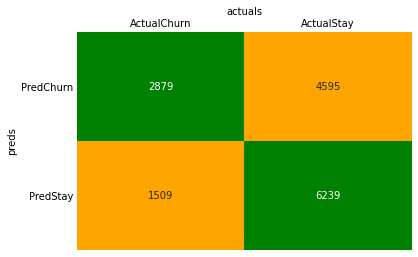

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

dfp = cm.pivot(index='preds', columns='actuals', values='count')

from matplotlib.colors import ListedColormap
cmap1 = ['orange', 'green', 'orange', 'green']
cmap = ListedColormap(cmap1) 

ax = sns.heatmap(dfp, annot = True, cbar=False, cmap=cmap, fmt='0')

#Just some plot adjustments to clean
ax.tick_params(length=0)
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

We can easily see our counts for TP (True Positives), FP (False Postives), TN (True Negatives), & FN (False Negatives). 

But we can go further and understand many more metrics, which may be more crucial depending on our business case. You can cut the confusion matrix a large number of ways (over 16 statistics are often calculated on the above 4 numbers!) but we will focus on the most commonly used. The key here is that saying we have 2751 true positives (alone) is fairly meaningless - we need to understand that against the other groups!

In [11]:
import numpy as np
##Sensitivity, Recall, or True Positive Rate - TP over all Positives
#  How many churning customers are we capturing
recall = np.sum(cm[(cm.preds == 'PredChurn') & (cm.actuals == 'ActualChurn')]['count'])\
                    /np.sum(cm[cm.actuals == 'ActualChurn']['count'])
recall

0.6561075660893345

In [12]:
##Precision or Positive Prediction Value - TP over all Predicted Positives
#  If we action all our predicted Churns, what % actually needed action
precision = np.sum(cm[(cm.preds == 'PredChurn') & (cm.actuals == 'ActualChurn')]['count'])\
                    /np.sum(cm[cm.preds == 'PredChurn']['count'])
precision

0.3852020337168852

In [13]:
##Fallout or False Positive Rate - FP over all Negatives
#  What rate of negatives are diluting our prediction strength
#  Again the idea of trade off - the lower we set our probability, the more FPs we let in.
fpr = np.sum(cm[(cm.preds == 'PredChurn') & (cm.actuals == 'ActualStay')]['count'])\
                    /np.sum(cm[cm.actuals == 'ActualStay']['count'])
fpr

0.42412774598486247

In [14]:
##Accuracy - True Predictions over all
#  A standard metric that is often avoided due to the fact it can often be high just by 
#  calling an entire class negative/positive.
acc = np.sum(cm[((cm.preds == 'PredStay') & (cm.actuals == 'ActualStay')) |
            ((cm.preds == 'PredChurn') & (cm.actuals == 'ActualChurn'))]['count'])\
                    /np.sum(cm['count'])
acc

0.5990014452765734

So have some metrics - lets make this simple.
- Recall/TPR - we want this high.
- Precision - we want this high.
- FPR - we want this low.
- Accuracy - we want this high, but be wary (remember the accuracy paradox)!

Keep in mind the values for ALL these metrics are dependant on our selected probability threshold (50% above).

So how did we get `auc` in previous lessons? What is a roc curve? A tpr/fpr curve? Essentially these are methods that better capture our metrics over the entire scope of our probability thresholds - and can help us identify where exactly we might want to set that probability.

Firstly let's build the table of probabilities threshold and values, then plot them - essentially calculate our above statistics at other probability splits than 50%.

In [15]:
import pandas as pd

##Set up empty dataframe
probs = pd.DataFrame({'prob':[], 'tpr':[], 
                     'prec':[], 'fpr':[]})

##Then run our confusion matrix function for each threshold in the range - 5,10,15,20 etc.
for i in range(0,105,5):
    
    cm = confusion_matrix(predictions, threshold = i/100)

    ##Using the returned dataframe from our conf matrix function, we then calculate our 
    ##evaluation statistics to measure both AUC ROC & AUC RVP
    recall = float(np.sum(cm[(cm.preds=='PredChurn') & (cm.actuals == 'ActualChurn')]['count'])\
            /np.sum(cm[cm.actuals == 'ActualChurn']['count']))
    
    ##Need to capture when precision is infinite (0 PredChurns)
    if np.sum(cm[cm.preds == 'PredChurn']['count'])==0:
        precision = 1
    else:
        precision = float(np.sum(cm[(cm.preds=='PredChurn') & (cm.actuals == 'ActualChurn')]['count'])\
            /np.sum(cm[cm.preds == 'PredChurn']['count']))
    
    fpr = float(np.sum(cm[(cm.preds=='PredChurn') & (cm.actuals == 'ActualStay')]['count'])\
            /np.sum(cm[cm.actuals == 'ActualStay']['count']))
    
    acc = float(np.sum(cm[((cm.preds=='PredStay') & (cm.actuals == 'ActualStay')) |
            ((cm.preds=='PredChurn') & (cm.actuals == 'ActualChurn'))]['count'])\
        /np.sum(cm['count']))
    
    probs = probs.append({'prob':(i/100), 'tpr':recall, 
                     'prec':precision, 'fpr':fpr}, ignore_index = True)

In [16]:
probs[:10]

prob       tpr      prec       fpr
0  0.00  1.000000  0.288267  1.000000
1  0.05  1.000000  0.288267  1.000000
2  0.10  0.999772  0.288239  0.999908
3  0.15  0.998861  0.288792  0.996308
4  0.20  0.986782  0.296616  0.947757
5  0.25  0.966272  0.305850  0.888222
6  0.30  0.939608  0.316302  0.822596
7  0.35  0.902689  0.329205  0.744970
8  0.40  0.850501  0.343457  0.658483
9  0.45  0.779626  0.362471  0.555381

Using our new shiny table, lets create two key plots that might let us know whats going on. Below we are just adding a flat line to plot as well (in purple), to show us the base threshold - i.e. if we just flipped a coin!

In [17]:
##50% axis line
probs['group']='GBT'
probs = probs.append(pd.DataFrame({'prob':[x/100 for x in range(0,105,5)],
                          'tpr':[x/100 for x in range(0,105,5)], 
                          'prec':[x/100 for x in range(0,105,5)], 
                          'fpr':[x/100 for x in range(0,105,5)],
                          'group':'Threshold'}), ignore_index = True)

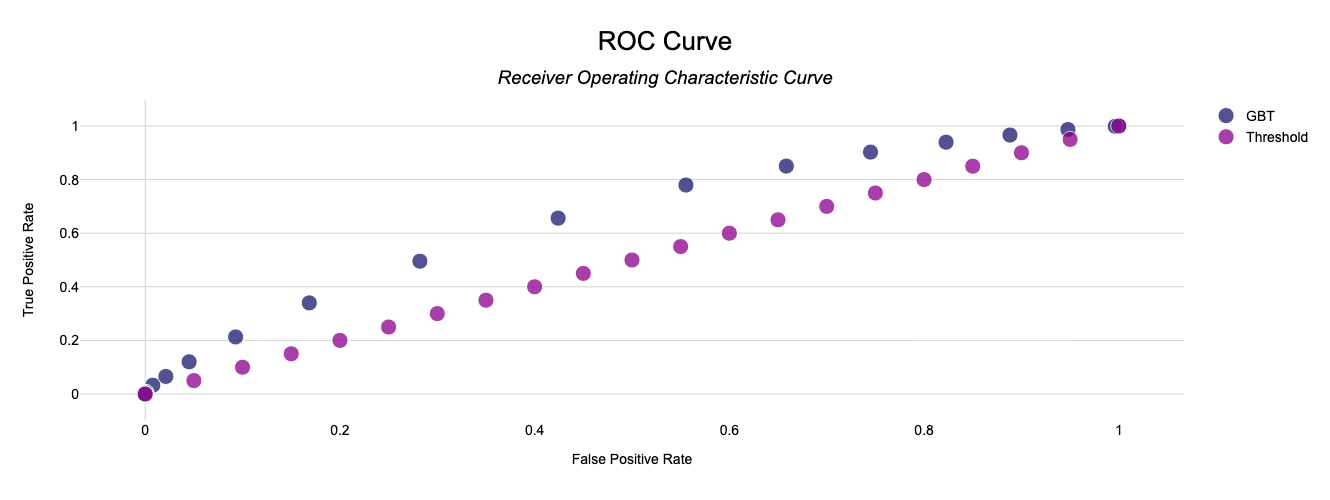

In [18]:
viz.plotlys(probs, 'fpr', 'tpr', kind = 'Scat', title = 'ROC Curve',
               subtitle = 'Receiver Operating Characteristic Curve',
               xtitle = 'False Positive Rate', ytitle = 'True Positive Rate',
               group = 'group')

We are going to break open the plotly function a little to make some customisations - mainly to help us understand at what probability the tpr/fpr values are occuring! We can still use `viz.plotly_layout()` to keep branding consistent.

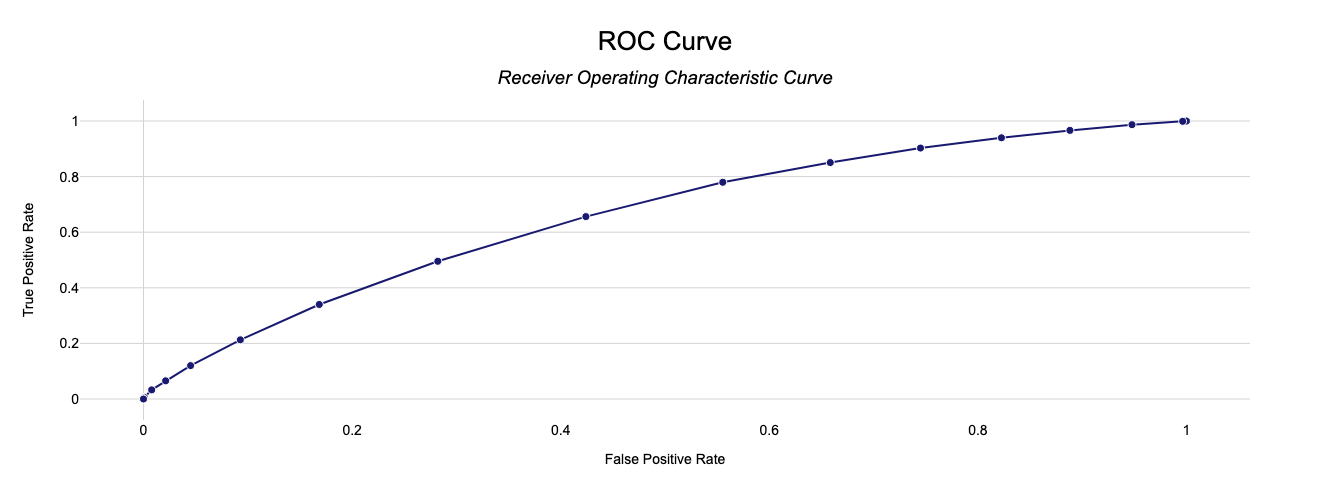

In [19]:
#Add in probabilities

import plotly
import plotly.graph_objs as go

df = probs[probs.group=='GBT']

base = [go.Scatter(
                x = df['fpr'], y = df['tpr'],
                marker=dict(color='midnightblue',
                            line=dict(color='white',width=1),
                            size = 8),
                text = df['prob'],
                hovertemplate = 'Prob Threshold: %{text}<br>TPR: %{y}<br>FPR: %{x}',
                mode = 'lines+markers', name = 'GBT Model')
                ]


fig = go.Figure(data = base, 
                layout = viz.plotly_layout(title = 'ROC Curve',
                               subtitle = 'Receiver Operating Characteristic Curve',
                               xtitle = 'False Positive Rate', ytitle = 'True Positive Rate'))
      
fig

It's a bit more work, but it allows us to hover over, and see at what probability threshold the tpr/fpr was calculated, it we decide to pick that threshold.

Below I will sketch up a quick 'ideal' ROC Curve - you will see it is steeper, again with a high TPR value matched with a low FPR value.

In [20]:
ideal = pd.DataFrame({'tpr':[0, 0.5, 0.7, 0.85, 0.9, 0.94, 0.96, 0.97, 0.98, 0.99, 0.995, 1],
                'fpr':[0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                'prob':[1, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]})

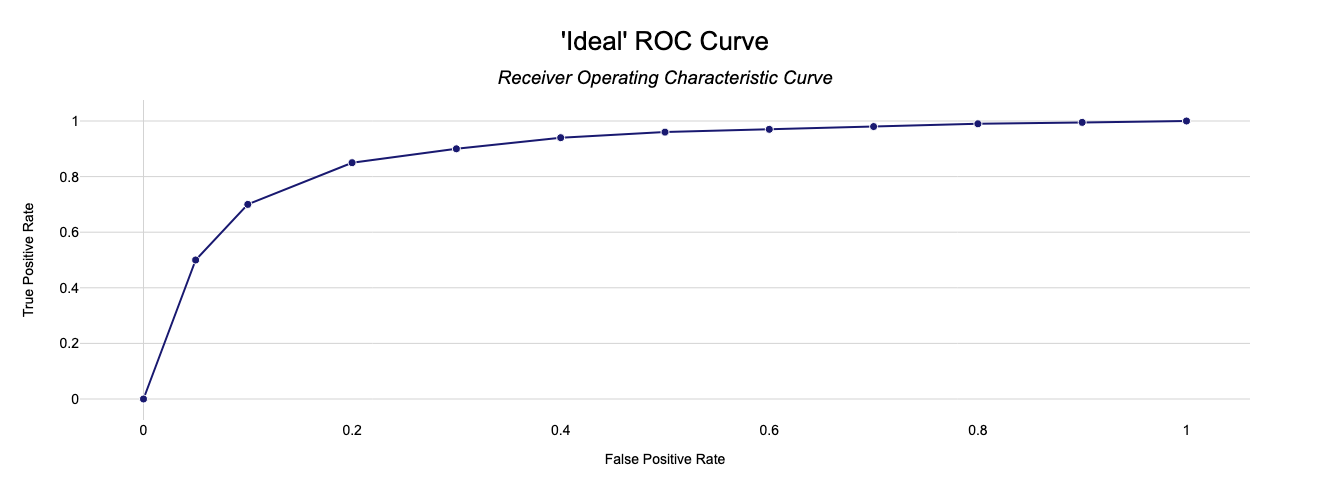

In [21]:
base = [go.Scatter(
                x = ideal['fpr'], y = ideal['tpr'],
                marker=dict(color='midnightblue',
                            line=dict(color='white',width=1),
                            size = 8),
                text = ideal['prob'],
                hovertemplate = 'Percent: %{text}<br>TPR: %{y}<br>FPR: %{x}',
                mode = 'lines+markers', name = 'GBT Model')
                ]


fig = go.Figure(data = base, 
                layout = viz.plotly_layout(title = "'Ideal' ROC Curve",
                               subtitle = 'Receiver Operating Characteristic Curve',
                               xtitle = 'False Positive Rate', ytitle = 'True Positive Rate'))
        
fig

The above 'ROC' Curve is used to calculate our AUC - the area under our roc curve. The more area under the curve represents our TPR reaching ~1 at a lower FPR, i.e. we are finding almost all the Churn with very little noise in the form of False Positives.

**Summary - higher AUC is good!**

--

The Recall/Precision Curve is a little different again. While ROC AUC is measuring how much *noise* we might let in for each extra *true* event if we are less strict on our thresholds, this curve looks to understand a similar thing but with the focus on the positive class (Churners) - making it useful for models with skewed or imbalanced populations. So while we can get 70% of the churners at a certain probability threshold, only 40% of what we would end up calling 'Churners' would actually churn. Again this is a cost trade off - do we pay to do whatever action we decide if it will be wasted on 60% of our group?

To clarify:
- ROC tests "if we call anything above x% probability 'Churn', what % of the Churners do we catch (GOOD), and what % of Stayers do we call Churners (BAD)?" - What % of the negative group may be affected by actions we enact on the labelled positive group vs what proportion of the positive group may end up ignored?
- PvR tests "if we call anything above x% probability 'Churn', what % of our group called Churners are actually Churners (GOOD), and what % of Churners do we catch (GOOD)?" - what proportion of the positive group may end up ignored vs how wasteful may the actions we enact on the labelled positive group be?




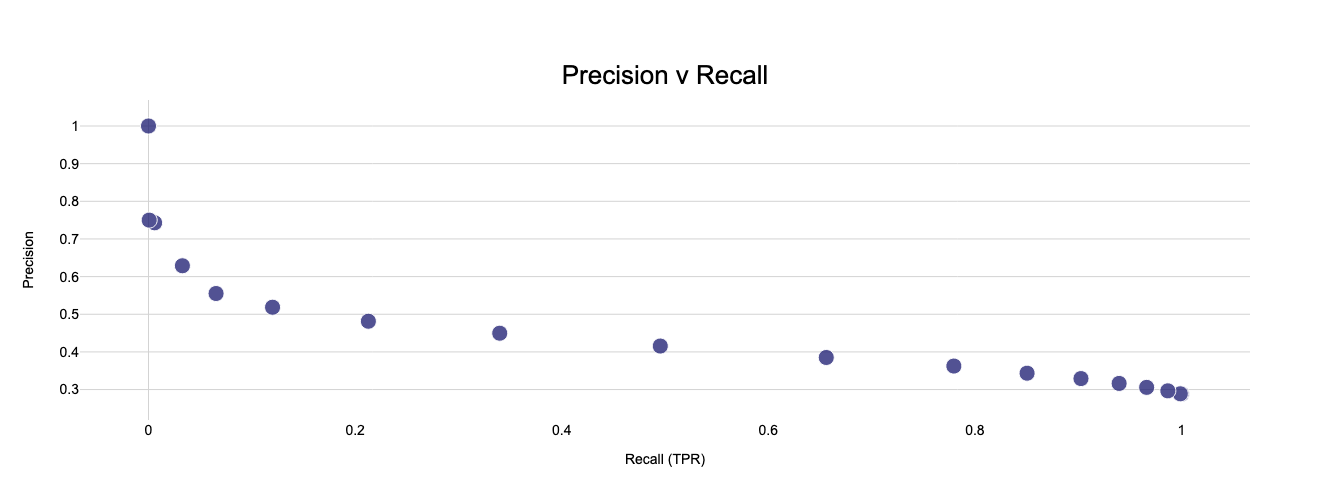

In [22]:
##tpr/recall - what percent of relevant items did we capture, precision - how many of the items we captured were relevant?
viz.plotlys(df, 'tpr', 'prec', kind = 'Scat',
              title = 'Precision v Recall', xtitle = 'Recall (TPR)',
              ytitle = 'Precision')

Again, for P/R, a larger 'area under the curve' is better - most of what we call churn IS churn, without letting in too much noise (high precision at all values of TPR). **Note** that the baseline on the Y axis is dependant on the ratio of Positives to Negatives. As our ratio is around 1:2.5, our baseline is around 1/3.5 (0.28).

For when to use ROC vs Prec/Rec, I suggest you do some further reading [here](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/). In practice it is simple enough to get all the evaluation metrics and compare them in the context of your work.

For your reference - an ideal P/R curve below.

In [23]:
ideal = pd.DataFrame({'tpr':[0, 0.5, 0.7, 0.8, 0.9, 0.93, 0.94, 0.95, 0.97, 0.98, 0.99, 1],
                'precision':[1, 0.99, 0.98, 0.97, 0.95, 0.93, 0.915, 0.9, 0.85, 0.8, 0.7, 0.5],
                'prob':[1, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]})

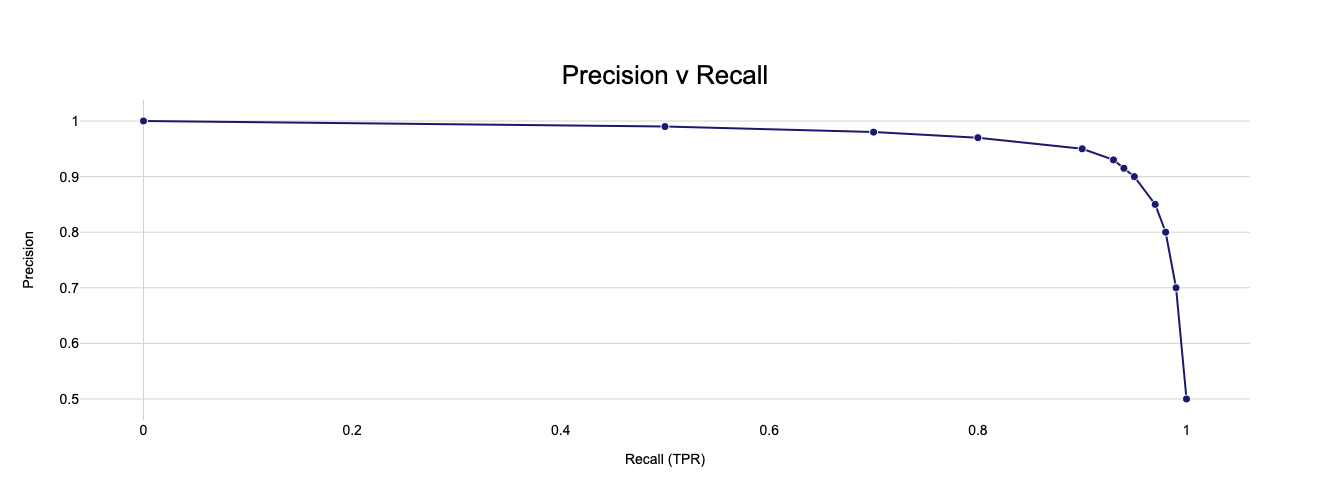

In [24]:
base = [go.Scatter(
                x = ideal['tpr'], y = ideal['precision'],
                marker=dict(color='midnightblue',
                            line=dict(color='white',width=1),
                            size = 8),
                text = ideal['prob'],
                hovertemplate = 'Prob Threshold: %{text}<br>Prec: %{y}<br>Recall: %{x}',
                mode = 'lines+markers', name = 'GBT Model')
                ]


fig = go.Figure(data = base, 
                layout = viz.plotly_layout(title = 'Precision v Recall', 
                                           xtitle = 'Recall (TPR)',
                                           ytitle = 'Precision'))
        
fig

---

Now we understand what 'area under the curve' for both of these curves is actually implying, lets calculate the metrics themselves. We will focus on demonstrating this with ROC AUC. The following literally maps the area under the shape created in our earlier visual.

In [25]:
##Finds the area under a line geometrically
1+np.trapz(df.fpr,df.tpr)

0.6592248940630371

Keep in mind the above literally uses our points to find the area under the curve. Meaning we can get quite a different metric the fewer thresholds we run it across - it linearly links points (straight line) instead of curving like we would expect. In fact we got ~66% in the last lesson using a built in function - and this is why. Let's compare our manual process above with some built in spark evaluators.

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")

##Running our evaluation on our test predictions
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC) on test data = %g" % auc)

Area Under the Curve (AUC) on test data = 0.660616


Why is this slightly higher? Well if we think about how we created our curve we need to ask - how many thresholds did the above run at? Because the 'flatter' our joins between points inherently reduces the 'curve' of the curve, reducing (ever so slightly) the area under it.

Now this is perhaps a tad advanced, but we can dig into the source code [here](https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.scala). We can see the default is set to run at 1000 thresholds (plenty) compared to our 20. 

This might sound 'advanced' - but this is the level of critical thinking that is expected of a data scientist - be suspicious of the numbers you see, run multiple functions & understand why they might return different results and which is the most sensible.

As an FYI - we can also get our area under our **Precision/Recall** curve.

In [27]:
evaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderPR")

##Running our evaluation on our test predictions
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC PvR) on test data = %g" % auc)

Area Under the Curve (AUC PvR) on test data = 0.426504


Not great!

---

Let's clean up some of our functions for future use.

In [28]:
def evaluate(predictions, thresholds = range(0,101,10)):
    
##    Will shoot out two visuals - ROC Curve & Probability distribution. 
    
    ##Probability Distribution
    from IPython.display import display
    
    probC=udf(lambda v:float(v[1]),FloatType())

    probsDist = predictions.select('Churn', probC('probability').alias('probC')).\
            withColumn('prob', round(col('probC')*5,1)/5).\
            withColumn('actuals', when(col('Churn')==1, 'ActualChurn').otherwise('ActualStay')).\
            groupBy('actuals', 'prob').count().\
            withColumn('perc', round(col('count')/sum(col('count')).
                           over(Window.partitionBy('actuals'))*100,2)).\
            toPandas()
    
    display(viz.plotlys(probsDist, 'prob', 'perc', kind = 'Bar', group = 'actuals',
              title = 'Probability Distribution', ytitle = "Percent of 'Actual' Group (%)",
              xtitle = 'Probability of Churn', width = 750))
    ##
    
    
    evP = BinaryClassificationEvaluator(
        labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderPR")
    evR = BinaryClassificationEvaluator(
        labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")

    ##Running our evaluation on our test predictions
    aucP = evP.evaluate(predictions)
    aucR = evR.evaluate(predictions)
    
    ## probs 
    import pandas as pd
    probs = pd.DataFrame({'prob':[], 'tpr':[], 
                         'prec':[], 'fpr':[]})

    for i in thresholds:

        #print('Running for probability {}'.format((i/100)))
        cm = confusion_matrix(predictions, threshold = i/100)

        recall = float(np.sum(cm[(cm.preds=='PredChurn') & (cm.actuals == 'ActualChurn')]['count'])\
                /np.sum(cm[cm.actuals == 'ActualChurn']['count']))

        ##Need to capture when precision is infinite (0 PredChurns)
        if np.sum(cm[cm.preds == 'PredChurn']['count'])==0:
            precision = 1
        else:
            precision = float(np.sum(cm[(cm.preds=='PredChurn') & (cm.actuals == 'ActualChurn')]['count'])\
                /np.sum(cm[cm.preds == 'PredChurn']['count']))

        fpr = float(np.sum(cm[(cm.preds=='PredChurn') & (cm.actuals == 'ActualStay')]['count'])\
                /np.sum(cm[cm.actuals == 'ActualStay']['count']))
        acc = float(np.sum(cm[((cm.preds=='PredStay') & (cm.actuals == 'ActualStay')) |
                ((cm.preds=='PredChurn') & (cm.actuals == 'ActualChurn'))]['count'])\
            /np.sum(cm['count']))
        probs = probs.append({'prob':(i/100), 'tpr':recall, 
                         'prec':precision, 'fpr':fpr}, ignore_index = True)
        
    
    
    #Add in probabilities

    import plotly
    import plotly.graph_objs as go

    df = probs

    base = [go.Scatter(
                    x = df['fpr'], y = df['tpr'],
                    marker=dict(color='midnightblue',
                                line=dict(color='white',width=1),
                                size = 8),
                    text = df['prob'],
                    hovertemplate = 'Percent: %{text}<br>TPR: %{y}<br>FPR: %{x}',
                    mode = 'lines+markers', name = 'GBT Model')
                    ]


    fig = go.Figure(data = base, 
                    layout = viz.plotly_layout(title = 'ROC Curve',
                                   subtitle = 'Receiver Operating Characteristic Curve',
                                   xtitle = 'False Positive Rate', 
                                   ytitle = 'True Positive Rate'))
    print('\n')
    display(fig)

    print('AUC ROC: %g' % aucR)
    print('AUC PvR: %g' % aucP)

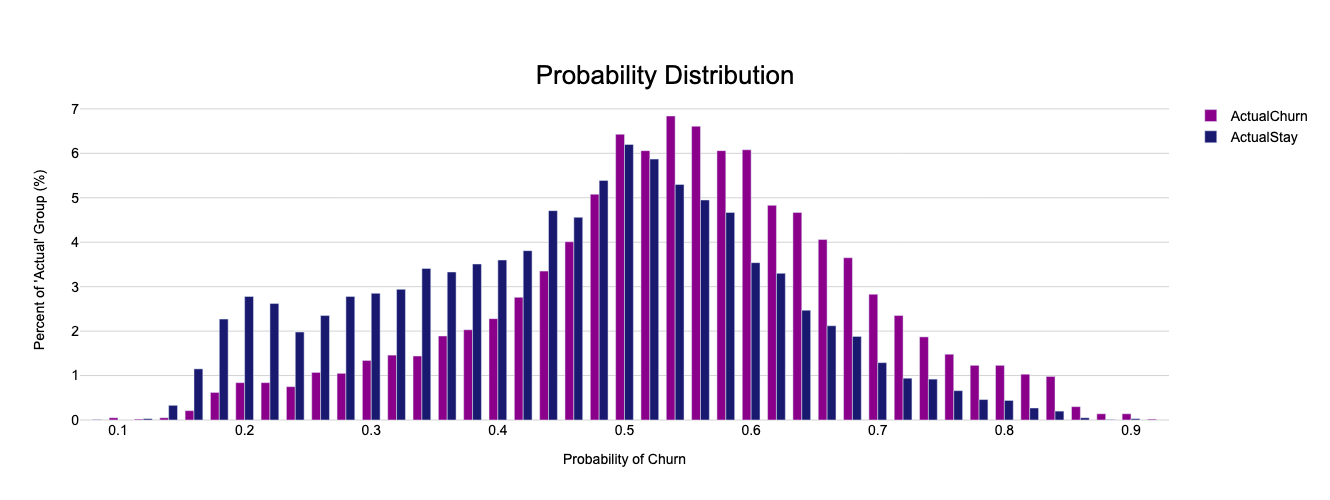

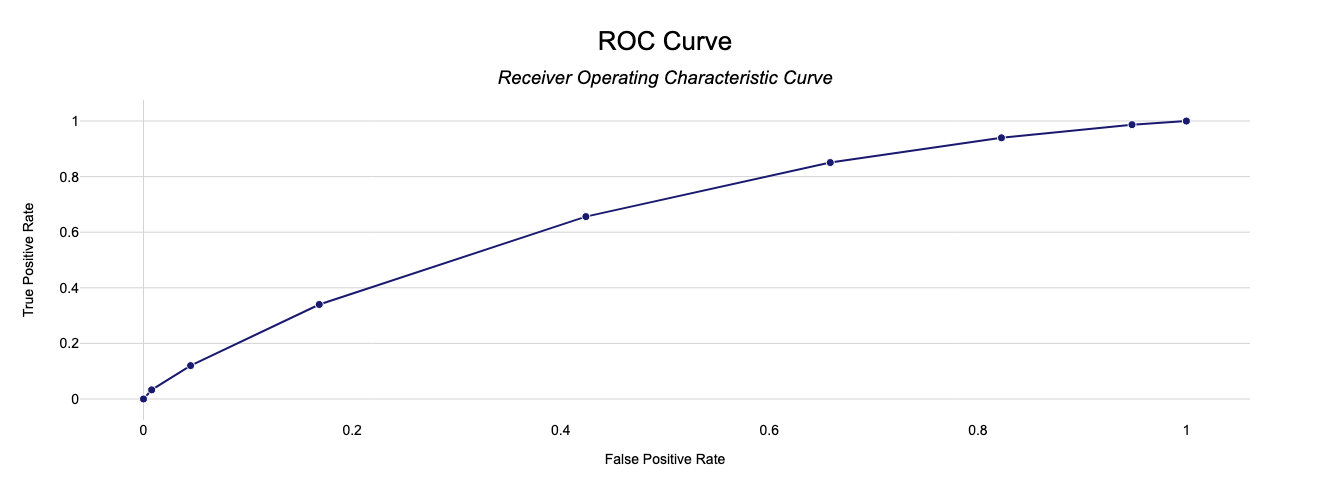

AUC ROC: 0.660613
AUC PvR: 0.426493


In [29]:
evaluate(predictions)

Two last points to cover off.

- These metrics are meaningless for comparison on *other* models/problems/etc. That is, **there is no generic standard for 'good'**. Your data set may be full of powerful leading indicators & your focus may be boosting 99 to 99.9% AUC. Or your problem may be one with few historical examples of an event to learn from, and a baseline set by current business processes may be all you are trying to beat for your first iteration. 

> These metrics purely aid in different feature/different model comparison on the **SAME TRAINING SET**. Whether or not your model is good enough will often be a business decision based on risk - if we get x% wrong, what does that mean for our business? Angry customers? More money spent than gained? Confusion?

- So I now understand the spectrum of my probability thresholds. **But which one do I pick?!** Again this is where the business problem comes in - it is a risk decision, not necessarily a statistics one. If your model could identify cancer early, but requires expensive & invasive surgery, how critical is avoiding False Positives? 

> Another way to understand it, is your model can essentially ORDER the population by likelihood to churn (in this case). Maybe you can set up different actions/responses by threshold? >90%, personally call customer. 80%> send bonus data allowance. <30% ignore. 30-80% maybe prioritise in certain campaigns. The key here - do not feel you have to approach this set with a binary action. For more information, a good article can be found [here](http://www.fharrell.com/post/classification/). It goes into depth about the understanding of this choice, and even shows why the industry's approach in general is flawed. 

There are plenty more metrics we can delve into, and there is a similar set for regression evaluation - however these are a little easier to understand as they are based on the numeric error between prediction and actual. We have covered the key ones here, and the methods required to calculate them. Let's move into more complicated territory - hyperparameters. 

---
---

## Hyperparameters

Hyperparameters are simply tuning configurations you can alter for your algorithms. For decision trees that might be how many splits you will allow, or how many leaves each branch must end with. Often when changing these, the focus is on balancing predictive power with overfitting. A deeper model for example may be great at predicting on your training set - but terrible at generalising because it was forced to create so many rules that it ended up making ones super specific to the patterns it found purely in the training set.

We will focus on Random Forests, as they have quite a few hyperparameters available, and are easy to understand. Each and every algorithm we have used have hyperparameters and it would take too long to go through them all - instead this will be your job to in future projects take the time to better  understand the mathematical construction behind each algorithm & thus the effect each of its hyperparameters have on it. You can find out your options from your pyspark functions, then research them if that is easiest.

In [30]:
from pyspark.ml.classification import RandomForestClassifier

##We insert our hyperparameters in here, but will leave blank for now.
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Churn', seed = 2019)
## Fit on our training data as before
rfModel = rf.fit(train)

## Predict on our test
predictions = rfModel.transform(test)

##Evaluate! We will use ROC AUC here.
evaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")

##Running our evaluation on our test predictions
auc = evaluator.evaluate(predictions)
print("Area Under the Curve (AUC PR) on test data = %g" % auc)

Area Under the Curve (AUC PR) on test data = 0.639436


Hmm so our baseline with Random Forest default hyperparameters is 63.3% AUC. Let's see what impact changing them may have. We will create a quick function to minimise our code, producing both our training & test ROC AUC.

I pulled the hyperparameters below straight from the spark RandomForestClassifier function - the defaults listed in the function are the defaults spark uses (and thus what our above AUC is based on).

In [31]:
print(' - ', str(RandomForestClassifier().explainParams()).replace('\n', '\n\n - '))

 -  bootstrap: Whether bootstrap samples are used when building trees. (default: True)

 - cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)

 - checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)

 - featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1

Another little function to allow us to alter the hyperparameters & immediately test performance.

In [32]:
def rfAUC(maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, numTrees = 20):
    ##Allows us to run a RF model & immediately shoot out evaluation metrics :)
    
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Churn',
                                maxDepth=maxDepth, 
                                maxBins=maxBins,
                                minInstancesPerNode=minInstancesPerNode, 
                                minInfoGain=minInfoGain, 
                                numTrees = numTrees,
                               seed = 2019)
    rfModel = rf.fit(train)
    
    predictionstr = rfModel.transform(train)
    predictions = rfModel.transform(test)
    
    evaluator = BinaryClassificationEvaluator(
        labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")

    return({'TrAUC':evaluator.evaluate(predictionstr),
           'TeAUC':evaluator.evaluate(predictions)})

In [33]:
trAUC, teAUC = rfAUC().values()
print('Baseline Train AUC: %g' % trAUC, \
      '\nBaseline Test AUC: %g' % teAUC)

Baseline Train AUC: 0.665288 
Baseline Test AUC: 0.639436


In [34]:
depthtr, depthte = rfAUC(maxDepth = 10).values()
print('Train Diff: %g' % (trAUC-depthtr))
print('Test Diff: %g' % (teAUC-depthte))

Train Diff: -0.159133
Test Diff: -0.012748


In [35]:
insttr, instte = rfAUC(minInstancesPerNode = 10).values()
print('Train Diff: %g' % (trAUC-insttr))
print('Test Diff: %g' % (teAUC-instte))

Train Diff: 0.0031546
Test Diff: -0.000781654


In [36]:
alltr, allte = rfAUC(maxDepth=30, maxBins=64, 
                     minInstancesPerNode=1, minInfoGain=0.0).values()
print('Train Diff: %g' % (trAUC-alltr))
print('Test Diff: %g' % (teAUC-allte))

Train Diff: -0.334697
Test Diff: 0.0126846


The key thing we are seeing here is how minimally our hyperparameter tuning is altering our result (the baseline training/test AUC at the top, the differences presented for the rest - max gain is only 0.015.). This is absolutely a possibility. The adage 'garbage in, garbage out' has never been truer than in machine learning - if you don't give it valuable patterns in the form of features, it can only do so much. Just to prove it let's run our set through a massive neural net (deep learning).

It is interesting to note that some of the above models seem to be (ever so slightly) better at generalising i.e. training evaluation is lower than baseline, but test is higher.

In [37]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [train.schema["features"].metadata["ml_attr"]["num_attrs"], 
          50, 40, 30, 20, 10, 5, 2]

trainer = MultilayerPerceptronClassifier(featuresCol = 'features',
                                         labelCol = 'Churn',
                                         layers=layers, maxIter = 100, seed = 2019)
nnModel = trainer.fit(train)

predictionstr = nnModel.transform(train)
predictions = nnModel.transform(test)

evaluator = BinaryClassificationEvaluator(
        labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")
print('TrAUC:',evaluator.evaluate(predictionstr))
print('TeAUC:',evaluator.evaluate(predictions))

TrAUC: 0.6029940244424539
TeAUC: 0.600904126396373


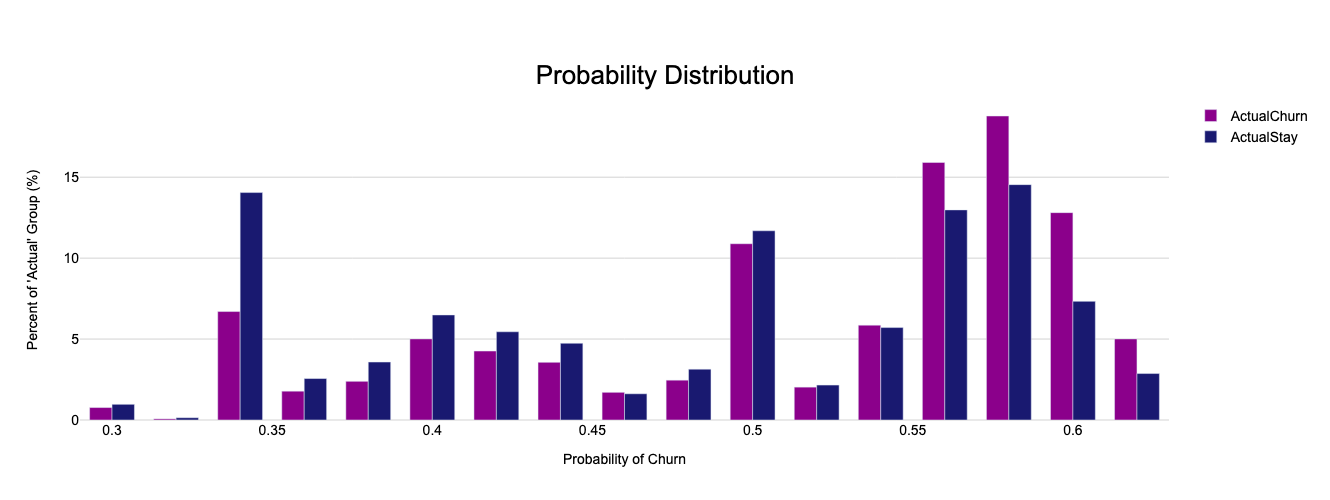

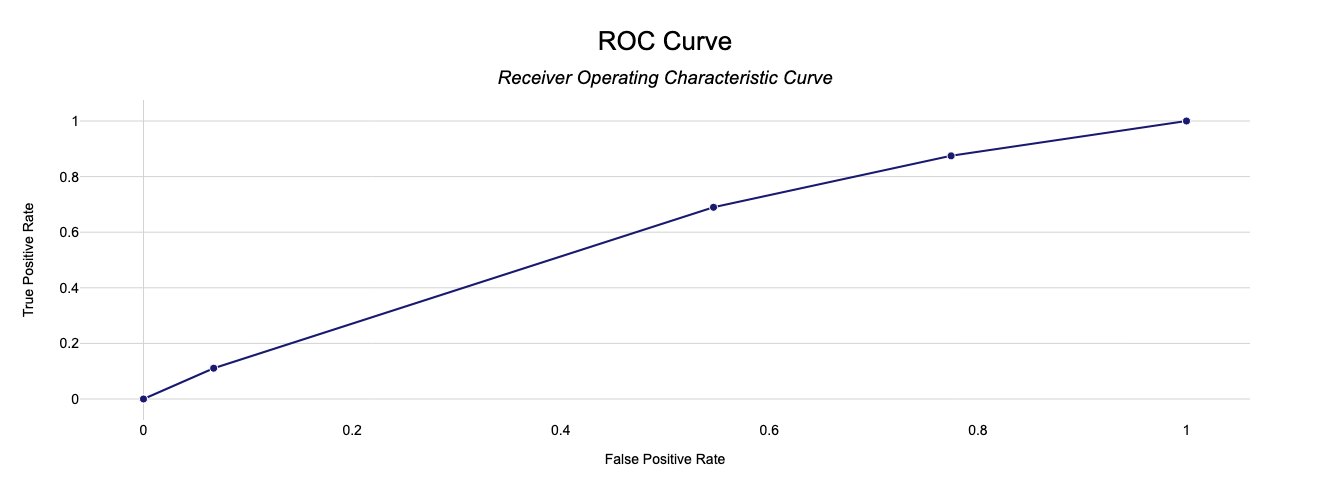

AUC ROC: 0.600877
AUC PvR: 0.360311


In [38]:
evaluate(predictions)

An 8 layer Neural Net and 100 iterations could only squeeze 60% AUC out of our feature set.

This point is critical. Honestly it is very easy to create a machine learning model. The difficulty is usually in feature engineering, and the imagination involved in squeezing every little bit of improvement out of it. This is a skill most of you already have, learnt over years of experience in your areas, and often specific technical analysis. Hyperparameters will not save a terrible model - they can however make a good model even better.

Understanding the multiple algorithms out there and their specific hyperparameters is something you can tackle as it comes up - but do not assume there is one 'best model algorithm'. Often the strongest solutions can be an ensemble model of multiple weaker models - essentially using the predictions of several models to create another prediction, covering the gaps of each individual model. So feel empowered to explore!

---
---

## Cross Validation

One last technique I want to leave you with is Cross-Validation (CV). Up to now we have been using a train/test set construct. One of the cons of this, especially when you have a smaller set is that you explicitly prevent your model from learning from valuable samples - in our case almost 10k samples. CV instead cycle through your data, essentially repeating your training process using a process called bagging. 

An example could be '10-fold CV', where 10% of the data is pulled out each loop, and used to test or 'validate'. It is then put back in, and another 10% is pulled out, and so on, 10 times. This way your model is trained on all of your data, without creating overfitting bias, or at least minimising it. 

Let's see if the technique can help us, we will still use our undersampled set, but add in all the test values too - the slight imbalance here is acceptable (but you could map it 1:1 again if you wanted).

In [39]:
fullset = train.union(test).cache()
fullset.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|14503|
|    0|21020|
+-----+-----+



Another function for our reuse, this will let us play with different folds, algorithms, evaluations etc. Essentially it breaks apart our full data into appropriate train/test pairs.

In [40]:
def kFoldCV(sdf, algo, evl, folds):
    """
    Breaks apart a full sdf into train/test pairs for a classification cross validation. 
    Each model is trained and evaluation metric is output to allow for further analysis.
    """
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    import statistics as st
    import numpy
    
    ##Assigns a random decimal between 0 & 1
    sdf = sdf.withColumn('rand', rand(seed = 2019))
    
    ##Chosen folds
    folds = folds
    b = 1/folds

    results = []

    #Cycle through folds, ensuring different % of data is test each time (based on uniform random number assigned)
    for n in range(folds):
        #Giving a number for example between 0 & 0.33, .33 & .67 etc. - a lower bound and upper bound.
        lb = n*b
        ub = (n+1)*b
        
        #Selecting our test portion
        test = sdf.filter((col('rand')>=lb) & (col('rand')<ub))
        train = sdf.join(test.select('CustomerID'), on = 'CustomerID', how = 'left_anti').cache()

        #Summary stats just to make sure appropriately stratified, appropriate volume etc.
        trc, tec, trcc, tecc = (train.count(), test.count(), 
                                train.filter(col('Churn')==1).count(),
                                test.filter(col('Churn')==1).count())

        print("\nFold {}\nTrain Size: {} | Test Size: {}".format(n+1, trc, tec))
        print("Train Churn %: {} | Test Churn %: {}".format(np.round(trcc/trc,2), np.round(tecc/tec,2)))

        #Train & Evaluate
        model = algo.fit(train)
        auc = evl.evaluate(model.transform(test))

        #Save & print metric
        results.append(auc)
        print("Eval Metric:", auc)

    
    print("\n\nAverage Eval Metric: {}\nStandard Deviation: {}".format(np.round(st.mean(results),4), 
                                                           np.round(st.stdev(results),4)))    
    
    return results

In [41]:
from pyspark.ml.classification import RandomForestClassifier

##Chosen algorithm
algo = RandomForestClassifier(featuresCol = 'features', labelCol = 'Churn', seed = 2019)

## Set up Evaluator
modelEvaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderROC")


res = kFoldCV(fullset, algo, modelEvaluator, 10)


Fold 1
Train Size: 19245 | Test Size: 3617
Train Churn %: 0.49 | Test Churn %: 0.41
Eval Metric: 0.6438707088996298

Fold 2
Train Size: 19524 | Test Size: 3611
Train Churn %: 0.49 | Test Churn %: 0.4
Eval Metric: 0.6424467817512564

Fold 3
Train Size: 19440 | Test Size: 3538
Train Churn %: 0.49 | Test Churn %: 0.41
Eval Metric: 0.6287662565580434

Fold 4
Train Size: 19338 | Test Size: 3561
Train Churn %: 0.49 | Test Churn %: 0.4
Eval Metric: 0.6318396835319451

Fold 5
Train Size: 19280 | Test Size: 3558
Train Churn %: 0.49 | Test Churn %: 0.42
Eval Metric: 0.6517766203722517

Fold 6
Train Size: 19339 | Test Size: 3623
Train Churn %: 0.49 | Test Churn %: 0.39
Eval Metric: 0.6397731281891041

Fold 7
Train Size: 19533 | Test Size: 3451
Train Churn %: 0.49 | Test Churn %: 0.41
Eval Metric: 0.644454637380508

Fold 8
Train Size: 19417 | Test Size: 3530
Train Churn %: 0.49 | Test Churn %: 0.42
Eval Metric: 0.6397281747285499

Fold 9
Train Size: 19460 | Test Size: 3553
Train Churn %: 0.48 | T

These multiple evaluations give us much more robust and informative measures with which to assess our model with. Instead of a single number, calculated from one train & test set, we cycle through to make sure no accidental bias is present (e.g. single test set happens to be particularly easy/hard to predict affecting evaluation). We can know test our spread and average evaluation metric - assuming normality in its distribution.

---

The above helps us break apart a single algorithm and consider the spread. Pyspark provides a more formal approach called `CrossValidator`. It takes an argument - `estimatorParamMaps` which is our way of doing hyperparameter tuning in our cross validation construct! 

Let's see how it works. I will also use a `Pipeline` to show you how easy it would be to have your full string encoder, scaler, assembler etc all in the one pipeline! Note if you want to perform stages such as scaling etc, you will need to set up your scaler into this pipeline, as you do not want summary statistics from the test set sneaking into your training data (called data leakage).

A key thing to note here is with a now full dataset (i.e. more data), 3 folds (i.e. 3 loops across train/test splits), and 2 hyperparameters tuning across 2 cuts, we are creating 12 models (3x(2 cuts x 2 cuts)). Cartesian products (matching every hyperparam option to each other option) are really easy to accidentally set up. This can take ages to run - so its worth sometimes running one hyperparameter set at a time manually, checking results, and changing. 

Finally, it outputs an actual model, not just metrics, and this model is created by running across all the data provided (as a training set) and using the chosen 'best' set up. This is for production use as discussed in our Measure presentation, not for evaluation, for the same reasons as before - it was trained on the patterns it is then being asked to predict on, introducing bias.

In [42]:
## We will reuse the algo & modelEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[algo])
paramGrid = ParamGridBuilder()\
            .addGrid(algo.maxDepth, [5])\
            .addGrid(algo.maxBins, [16,32])\
            .addGrid(algo.numTrees, [20,60])\
            .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3, seed = 2019)

## Train our model!
cvModel = crossval.fit(fullset)

Now we have trained our models, which set of hyperparameters did it end up selecting?

In [43]:
## We use 'stages' because we have used a pipeline. On our previous example you can omit this.
## Its not the prettiest code, but it will let you find the hyperparameters for future use, 
## replication etc. You can also get default/unchanging params just to be sure.

print("Selected Depth: %s" % cvModel.bestModel.stages[-1]._java_obj.getMaxDepth())
print("Selected Bins: %s" % cvModel.bestModel.stages[-1]._java_obj.getMaxBins())
print('Selected trees: %s' % cvModel.bestModel.stages[-1]._java_obj.getNumTrees())

Selected Depth: 5
Selected Bins: 32
Selected trees: 60


Let's see why.

In [44]:
##Getting our per-param average metrics

def cvEval(cvModel):
    ##Run just to get a simpler version of the params instead of their full details.
    params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

    import pandas as pd
    from IPython.display import display
    display(pd.DataFrame.from_dict([
            {**ps, cvModel.getEvaluator().getMetricName(): metric} 
            for ps, metric in zip(params, cvModel.avgMetrics)
        ]).\
            iloc[:,[1,2,3,0]].\
            sort_values('areaUnderROC')) ##Just to rearrange AUC to end of DF columns & order by AUC

cvEval(cvModel)

maxBins  numTrees  areaUnderROC  maxDepth
1       16        60      0.641243         5
0       16        20      0.642558         5
2       32        20      0.642831         5
3       32        60      0.643520         5

The above shows it selects the best set up (hyperparams in this case) based on our `modelEvaluator` (AUC) metric.

It returned a slight increase on our 63.3% AUC before as well! 

How about we try our GBT again from last lesson - even though the AUC was similar - is it better at splitting our cohort? Let's use the default hyperparameters, and 3 fold CV.

In [45]:
from pyspark.ml.classification import GBTClassifier
algo = GBTClassifier(featuresCol = 'features', labelCol = 'Churn', seed = 2019)

res = kFoldCV(fullset, algo, modelEvaluator, 3)


Fold 1
Train Size: 13673 | Test Size: 12009
Train Churn %: 0.5 | Test Churn %: 0.41
Eval Metric: 0.6552880187954169

Fold 2
Train Size: 13767 | Test Size: 11790
Train Churn %: 0.5 | Test Churn %: 0.4
Eval Metric: 0.6511750506177053

Fold 3
Train Size: 13939 | Test Size: 11724
Train Churn %: 0.49 | Test Churn %: 0.41
Eval Metric: 0.646510061440617


Average Eval Metric: 0.651
Standard Deviation: 0.0044


Pretty stable - though in practice we (as a rule of thumb) would use ~10 folds to better emulate our final model - trained on all the data. This is because a 10 fold process would result in the training to test size being 9:1 rather than our current 2:1, thus using more data for its pattern hunt!

Let's try using AUC PvR instead to evaluate our models.

In [46]:
pvrEvaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="probability", metricName="areaUnderPR")

res = kFoldCV(fullset, algo, pvrEvaluator, 3)


Fold 1
Train Size: 13673 | Test Size: 12009
Train Churn %: 0.5 | Test Churn %: 0.41
Eval Metric: 0.5418045759242405

Fold 2
Train Size: 13767 | Test Size: 11790
Train Churn %: 0.5 | Test Churn %: 0.4
Eval Metric: 0.5363298142042112

Fold 3
Train Size: 13939 | Test Size: 11724
Train Churn %: 0.49 | Test Churn %: 0.41
Eval Metric: 0.542462597927372


Average Eval Metric: 0.5402
Standard Deviation: 0.0034


Still not an amazing Precision v Recall.

The reason we are using this approach rather than using `CrossValidator` is because it allows us to properly understand the metrics from each fold - not just the final average. That function is better used for hyperparameter comparison ironically. To just show why we do this validation - let's see what would happen if we used a final model trained on all data then tried to evaluate the model on the exact same data.

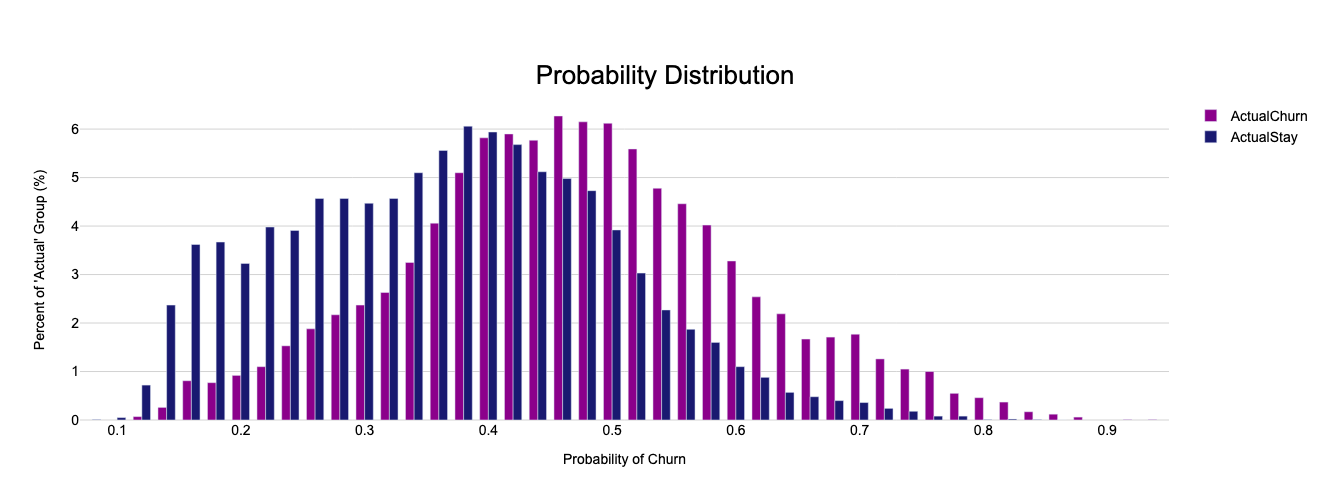

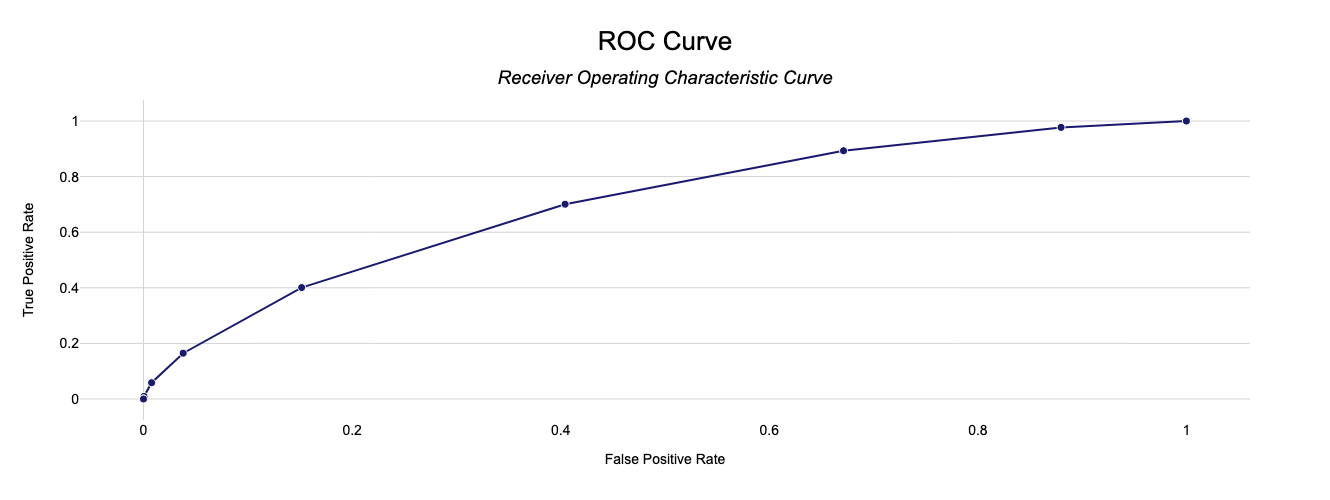

AUC ROC: 0.709948
AUC PvR: 0.624412


In [47]:
mod = algo.fit(fullset)
predictions = mod.transform(fullset)
evaluate(predictions)

As we can see, instead of our CV fold average AUC ROC of 65.5% and AUC PvR of 54.9%, it is reporting 71% and 62.2% respectively. This is a sizeable difference perhaps indicating some overfitting. CV allows us to better understand, that if we were to train a model on all of our data, we should expect a future AUC of ~65% and minimal deviance from that.

Let's finish off with one last model and see how it goes! Again we have two sets of hyperparameters with 2 options, and a 3-fold CV - 12 models will be run, so it may take time.

In [48]:
## We will reuse the algo & modelEvaluator

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[algo])
paramGrid = ParamGridBuilder()\
            .addGrid(algo.maxDepth, [5])\
            .addGrid(algo.maxBins, [16, 64])\
            .addGrid(algo.stepSize, [0.05, 0.1])\
            .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3, seed = 2019)

## Train our model!
cvModel = crossval.fit(fullset)

In [49]:
cvEval(cvModel)

maxBins  stepSize  areaUnderROC  maxDepth
0       16      0.05      0.654752         5
2       64      0.05      0.655587         5
3       64      0.10      0.661420         5
1       16      0.10      0.661943         5

In [50]:
##Let's double check the hyperparameter selection!
print("Selected Depth: %s" % cvModel.bestModel.stages[-1]._java_obj.getMaxDepth())
print("Selected Bins: %s" % cvModel.bestModel.stages[-1]._java_obj.getMaxBins())
print('Selected trees: %s' % cvModel.bestModel.stages[-1]._java_obj.getStepSize())

Selected Depth: 5
Selected Bins: 16
Selected trees: 0.1


Only pushed to 66.1% AUC but progress. If our current process involved flipping a coin, or just spamming everyone, this model might helps us get more specific in our targets. Here we might try adding more features, some different scaling, ensemble models etc.

---

One final visualisation/concept to help us understand the notion of prioritisation is the **'lift curve' or gains chart.** 

Basically, if we were to order everyone by their predicted probability of churn, how much of the entire population would we have to cover to 'gain' a certain percentage of the churners. This chart's goal is less around model comparison, but can help us & the business draw a line in the sand. With finite resources, where can I place them for maximum effect? And if I increased my resources, how much extra gain could I expect? Essentially it represents the idea of diminishing returns, and attaches it to our model. 

It will look alot like our ROC curve but do not be fooled - note the x & y axes.

In [51]:
#Again - we shouldn't be doing this on our 'training set' but it will do to show the concept.

#Probabilities from spark come as vectors e.g. (0.1,0.9) representing the negative and positive probability.
#This function simply selects the positive (Churn) probability.
probC=udf(lambda v:float(v[1]),FloatType())

probs = cvModel.bestModel.transform(fullset).\
                    select('Churn', round(probC('probability')*100).alias('probC')).\
                    groupBy('probC', 'Churn').count().toPandas()
probs[:5]

probC  Churn  count
0   26.0      0    505
1   19.0      0    332
2   68.0      0     38
3   22.0      1     83
4   77.0      0     12

In [52]:
##First process - 'pivoting' to set the Churn column's 1&0 as separate columns & 
##    ordering by highest churn probability first.
prob = probs.pivot('probC', 'Churn', 'count').reset_index().fillna(0).\
            sort_values('probC', ascending = False)

##Two calculations - cumulative % of total people as prob increases, & cumulative % of churners as prob increases.
prob['total'] = prob.apply(lambda x: (x[0]+x[1])/
                                   (prob[0].sum()+prob[1].sum()), axis = 1).cumsum()*100
prob['Churn'] = prob.apply(lambda x: x[1]/
                                    prob[1].sum(), axis = 1).cumsum()*100

prob[:5]

Churn  probC    0     1     total     Churn
83      92.0  0.0   1.0  0.002815  0.006895
82      91.0  0.0   1.0  0.005630  0.013790
81      90.0  0.0   1.0  0.008445  0.020685
80      89.0  0.0  10.0  0.036596  0.089637
79      88.0  6.0  15.0  0.095713  0.193064

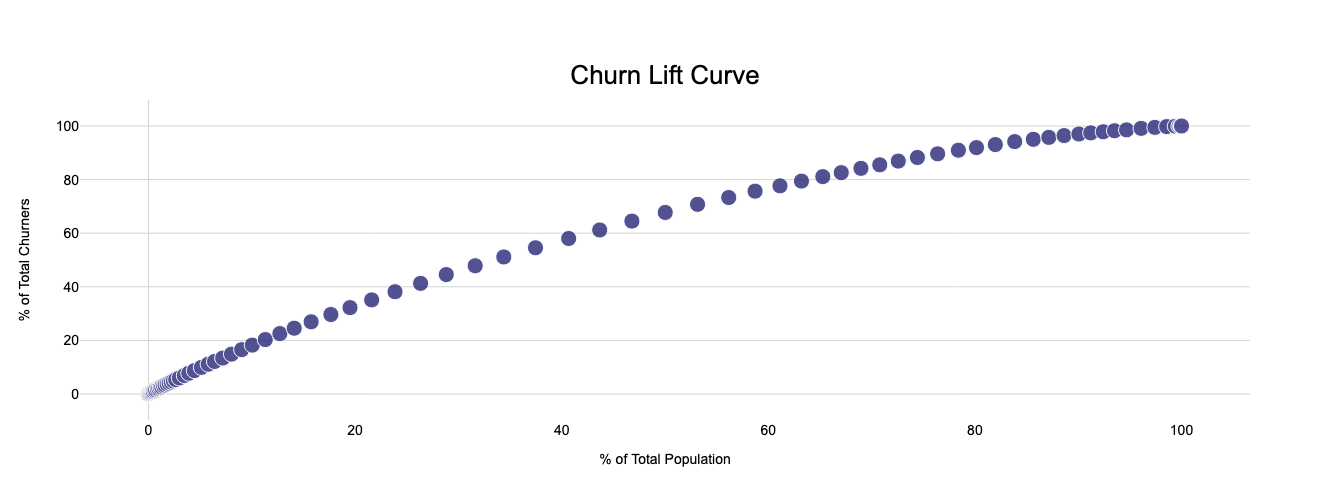

In [53]:
viz.plotlys(prob, 'total', 'Churn', kind = 'Scat',
              title = 'Churn Lift Curve', xtitle = '% of Total Population',
              ytitle = '% of Total Churners')

In [54]:
prob[prob.total<=42][-1:]

Churn  probC      0      1      total      Churn
36      45.0  638.0  503.0  40.677871  58.029373

There are several ways we can read this graph:
- If my action (response to prevent Churn) costs 1 dollar per customer per action, and I have 30k customers & only 12000 dollars total, I can only run an action on 40% of my population. This would result in me capturing ~60% of the possible churners (based on the y value for an x value of 40% - see above table).
- Find the point of diminishing returns (based on proportion of Churners to non-Churners) - where do I start having more Stayers than Churners (percent threshold) - and cap investment.
- Change investment along the curve - those with a higher risk of churn may justify more spend, and as that risk decreases, so too does the action spend.

Again, the steeper the curve (the quicker we capture 100% of churners with the smallest % of total population) indicates a powerful model.

---

## Now what? 

If we were stuck here, that is to say we had exhausted every model, every hyperparameter, every testing setup, we could get more examples, new features, or alter our target. There are numerous strategies available purely in the context of what we have been learning in the last 4 weeks. 

However if we decided that our model, in its infancy, while not perfect was better than BAU, we could ***definitely*** start to evolve that process with this model at its core. While change management activities and slow approvals happen in parallel, we can work on version 2! Never do your data science activities in isolation - ensure they have a goal state in the wider business (not just as a POC), and that you have the right people working on it, together!

---

## Wrap

We have learnt alot in these few weeks. By no means are you expected to be an expert already, and most established DSs will tell you they are still learning every day (I certainly learnt alot writing these tutorials!!). The key intention of these lessons were to give you some functioning code, help in understanding a practical level of statistics, feature engineering, ML etc, and having terms to go away and research deeper yourself as you continue your learning journey. Find a business problem in your area & brainstorm with your team if an analytical solution could help. Participate in kaggle competitions. Continue researching new techniques!

<hr>
<hr>

>One thing to reiterate as we close out is that **ACTION** is everything. Your model could be absolutely incredible, but until the business understands how it can fit into existing processes, or what it would take to change them, and what value your analytics can bring in that change, the status quo will continue to exist. We, as data scientists, must continue to push forward this intelligent approach to business model design to ensure our clients survive the changing environment in which we find our company. To do any of this requires our ability to understand and respond to these groups at scale - an approach which data science, if at our core, can achieve.

---
---

